In [1]:
# Cell 1: Setup & Imports
import os
import sys
import pickle
import numpy as np
import random
import string
from collections import Counter
from pathlib import Path

# --- Install missing libraries ---
try:
    import matplotlib.pyplot as plt
    import tqdm
    import rich
    import sklearn
except ImportError:
    print("Installing required libraries: matplotlib, tqdm, rich, scikit-learn")
    import matplotlib.pyplot as plt
    from tqdm import tqdm
    from rich.console import Console
# ---------------------------------

# --- Add Project Root to Python Path ---
# Navigate up one level from notebooks/ to project root
notebook_dir = Path.cwd()
if notebook_dir.name == "notebooks":
    project_root = notebook_dir.parent
else:
    project_root = notebook_dir

if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))
    print(f"✅ Added {project_root} to system path.")
# ---------------------------------------

# --- Import Your Project Files ---
from env.hangman_env import HangmanEnvironment
from hmm.train_hmm import predict_letter_probs, load_corpus
from rl.agent import QLearningAgent

# --- Define Key File Paths ---
CORPUS_PATH = project_root / "data" / "corpus.txt"
HMM_MODEL_PATH = project_root / "hmm" / "hmm_model.pkl"
POLICY_PATH = project_root / "rl" / "policy.pkl"
PLOT_PATH = project_root / "results" / "learning_curve.png"

print(f"📁 Project Root: {project_root}")
print(f"📊 Corpus: {CORPUS_PATH}")
print(f"🧠 HMM Model: {HMM_MODEL_PATH}")
print(f"🎯 Policy: {POLICY_PATH}")
print("\n✅ Setup complete. All modules imported successfully!")


Installing required libraries: matplotlib, tqdm, rich, scikit-learn
✅ Added c:\Users\reddy\Desktop\ML_Hackathon to system path.
📁 Project Root: c:\Users\reddy\Desktop\ML_Hackathon
📊 Corpus: c:\Users\reddy\Desktop\ML_Hackathon\data\corpus.txt
🧠 HMM Model: c:\Users\reddy\Desktop\ML_Hackathon\hmm\hmm_model.pkl
🎯 Policy: c:\Users\reddy\Desktop\ML_Hackathon\rl\policy.pkl

✅ Setup complete. All modules imported successfully!


Loading corpus from: c:\Users\reddy\Desktop\ML_Hackathon\data\corpus.txt
Total words in corpus: 49979
Min word length: 1
Max word length: 24
Avg word length: 9.50


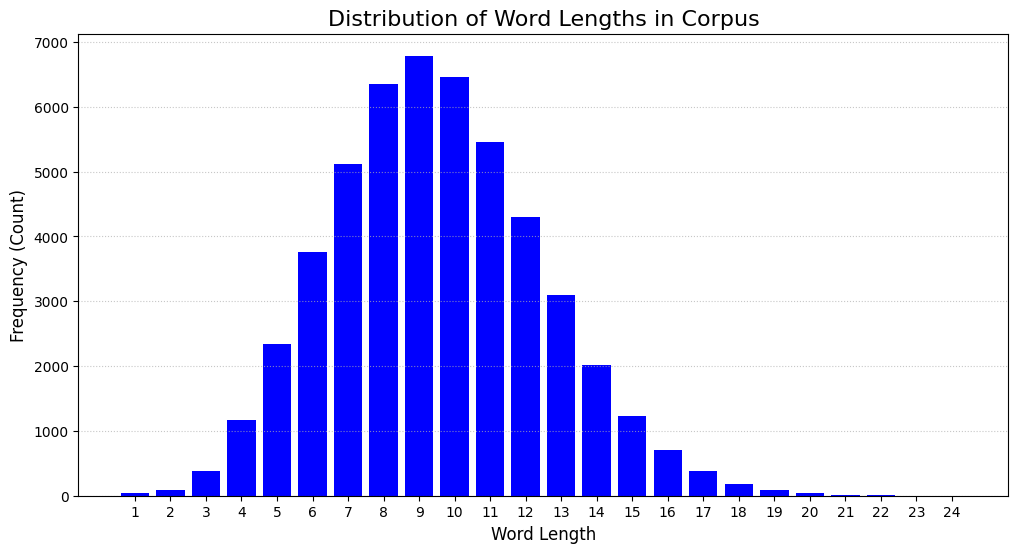

In [2]:
# Cell 2: Part 1 - Corpus Data Analysis
print(f"Loading corpus from: {CORPUS_PATH}")
words = load_corpus(CORPUS_PATH)
print(f"Total words in corpus: {len(words)}")

# --- Get word length stats ---
word_lengths = [len(w) for w in words]
length_counts = Counter(word_lengths)
min_len = min(length_counts.keys())
max_len = max(length_counts.keys())
avg_len = np.mean(word_lengths)

print(f"Min word length: {min_len}")
print(f"Max word length: {max_len}")
print(f"Avg word length: {avg_len:.2f}")

# --- Plot Word Length Distribution ---
plt.figure(figsize=(12, 6))
sorted_lengths = sorted(length_counts.items())
x = [item[0] for item in sorted_lengths]
y = [item[1] for item in sorted_lengths]

plt.bar(x, y, color='b')
plt.title("Distribution of Word Lengths in Corpus", fontsize=16)
plt.xlabel("Word Length", fontsize=12)
plt.ylabel("Frequency (Count)", fontsize=12)
plt.xticks(range(min_len, max_len + 1))
plt.grid(axis='y', linestyle=':', alpha=0.7)
plt.show()

In [3]:
# Cell 3: Part 2 - HMM Demonstration
print(f"Loading HMM model from: {HMM_MODEL_PATH}")
with open(HMM_MODEL_PATH, 'rb') as f:
    hmm_model = pickle.load(f)
print("✅ HMM model loaded (Original HMM).")

def show_hmm_prediction(masked_word, guessed_letters_str):
    """Helper function to demo the HMM."""
    guessed = set(guessed_letters_str.lower())
    # Use the predict_letter_probs function
    probs = predict_letter_probs(masked_word.lower(), guessed, hmm_model)
    
    print(f"\n--- HMM Test Case ---")
    print(f"Board: {masked_word} | Guessed: {{{', '.join(sorted(guessed)) if guessed else 'none'}}}")
    print("Top 5 Predictions:")
    for letter, prob in sorted(probs.items(), key=lambda item: item[1], reverse=True)[:5]:
        print(f"  {letter.upper()}: {prob:.4f}")

# --- Run Test Cases ---
print("\n🧪 Testing HMM with different game states:")
show_hmm_prediction("_______", "")
show_hmm_prediction("P_____N", "pn")
show_hmm_prediction("PYT___", "pyt")
show_hmm_prediction("_A__MA_", "am")


Loading HMM model from: c:\Users\reddy\Desktop\ML_Hackathon\hmm\hmm_model.pkl
✅ HMM model loaded (Original HMM).

🧪 Testing HMM with different game states:

--- HMM Test Case ---
Board: _______ | Guessed: {none}
Top 5 Predictions:
  E: 0.1079
  A: 0.0962
  I: 0.0798
  R: 0.0715
  O: 0.0647

--- HMM Test Case ---
Board: P_____N | Guessed: {n, p}
Top 5 Predictions:
  A: 0.1180
  E: 0.1177
  I: 0.1155
  O: 0.0885
  R: 0.0780

--- HMM Test Case ---
Board: PYT___ | Guessed: {p, t, y}
Top 5 Predictions:
  E: 0.1647
  A: 0.1034
  I: 0.0943
  N: 0.0808
  L: 0.0788

--- HMM Test Case ---
Board: _A__MA_ | Guessed: {a, m}
Top 5 Predictions:
  E: 0.1027
  R: 0.0875
  T: 0.0798
  S: 0.0787
  N: 0.0695


In [4]:
# Cell 4: Part 3 - RL Environment & Agent Design
print("--- Demonstrating the RL Environment ---")
env = HangmanEnvironment(corpus_path=CORPUS_PATH)
state = env.reset()
print(f"Secret word picked: {env.secret_word}")
env.render()

done = False
total_reward = 0
all_letters = list(string.ascii_uppercase)
random.shuffle(all_letters)

while not done:
    # A purely random agent
    action = all_letters.pop()
    if action in state["guessed_letters"]:
        action = all_letters.pop() # try again
    
    print(f"\nRandom Action: '{action}'")
    state, reward, done = env.step(action)
    
    print(f"  Reward: {reward}")
    print(f"  Done: {done}")
    env.render()
    total_reward += reward

print(f"\n--- Game Over ---")
print(f"Final Board: {state['masked_word']}")
print(f"Total Reward: {total_reward}")

--- Demonstrating the RL Environment ---
HangmanEnv: Successfully loaded 49979 words from c:\Users\reddy\Desktop\ML_Hackathon\data\corpus.txt
Secret word picked: RACHIGLOSSA
  Board: ___________   Lives: 6   Guessed: []

Random Action: 'C'
  Reward: 1
  Done: False
  Board: __C________   Lives: 6   Guessed: ['C']

Random Action: 'I'
  Reward: 1
  Done: False
  Board: __C_I______   Lives: 6   Guessed: ['C', 'I']

Random Action: 'T'
  Reward: -5
  Done: False
  Board: __C_I______   Lives: 5   Guessed: ['C', 'I', 'T']

Random Action: 'B'
  Reward: -5
  Done: False
  Board: __C_I______   Lives: 4   Guessed: ['B', 'C', 'I', 'T']

Random Action: 'W'
  Reward: -5
  Done: False
  Board: __C_I______   Lives: 3   Guessed: ['B', 'C', 'I', 'T', 'W']

Random Action: 'K'
  Reward: -5
  Done: False
  Board: __C_I______   Lives: 2   Guessed: ['B', 'C', 'I', 'K', 'T', 'W']

Random Action: 'L'
  Reward: 1
  Done: False
  Board: __C_I_L____   Lives: 2   Guessed: ['B', 'C', 'I', 'K', 'L', 'T', 'W']

Rando

In [5]:
# Cell 5: Part 4 - The Trained "Hybrid" Agent in Action
print("--- Demonstrating the Trained Hybrid Agent ---")

# 1. Load the trained agent
agent = QLearningAgent(epsilon=0.0) # Epsilon = 0, we want 100% smart choices
try:
    agent.load_policy(POLICY_PATH)
    print("✅ Trained policy.pkl loaded.")
except FileNotFoundError:
    print(f"❌ Policy file not found at {POLICY_PATH}. Please run rl/train_rl.py first.")

# 2. Load the HMM (if not already loaded from cell 3)
if 'hmm_model' not in locals():
    with open(HMM_MODEL_PATH, 'rb') as f:
        hmm_model = pickle.load(f)
    print("✅ HMM model loaded.")
else:
    print("✅ Using HMM model from previous cell.")

# 3. Setup Environment
env = HangmanEnvironment(corpus_path=CORPUS_PATH)
state_dict = env.reset()
print(f"\n🎮 New Game! Secret word is: {env.secret_word}") # For demo purposes
env.render()

done = False
total_reward = 0

while not done:
    # 1. Get the Q-table state
    state = agent.get_simple_state(state_dict)
    
    # 2. Get the HMM's "coach" advice
    hmm_probs = predict_letter_probs(
        state_dict["masked_word"].lower(),
        {l.lower() for l in state_dict["guessed_letters"]},
        hmm_model
    )
    
    # 3. Agent makes its final, hybrid decision
    action_letter = agent.choose_action(
        state, 
        hmm_probs, 
        state_dict["guessed_letters"]
    )
    
    # --- Show the "thoughts" of the agent ---
    print(f"\n🤖 Agent's Turn:")
    hmm_top_3 = sorted(hmm_probs.items(), key=lambda item: item[1], reverse=True)[:3]
    print(f"  💡 HMM's Top 3 Hints: {[(l.upper(), f'{p:.1%}') for l, p in hmm_top_3]}")
    print(f"  🎯 Hybrid Agent's Final Choice: '{action_letter}'")
    # ----------------------------------------
    
    # 4. Take the action
    state_dict, reward, done = env.step(action_letter)
    
    print(f"  💰 Reward: {reward}")
    env.render()
    total_reward += reward

print(f"\n{'='*60}")
print(f"🏁 GAME OVER")
print(f"{'='*60}")
print(f"Final Board: {state_dict['masked_word']}")
print(f"Total Reward: {total_reward}")
print(f"Result: {'🎉 WON!' if state_dict['lives_left'] > 0 else '💀 LOST'}")
print(f"Lives Remaining: {state_dict['lives_left']}/6")


--- Demonstrating the Trained Hybrid Agent ---
✅ Q-table policy loaded from c:\Users\reddy\Desktop\ML_Hackathon\rl\policy.pkl
✅ Trained policy.pkl loaded.
✅ Using HMM model from previous cell.
HangmanEnv: Successfully loaded 49979 words from c:\Users\reddy\Desktop\ML_Hackathon\data\corpus.txt

🎮 New Game! Secret word is: REFLUENCE
  Board: _________   Lives: 6   Guessed: []

🤖 Agent's Turn:
  💡 HMM's Top 3 Hints: [('E', '10.9%'), ('I', '8.9%'), ('A', '8.7%')]
  🎯 Hybrid Agent's Final Choice: 'E'
  💰 Reward: 1
  Board: _E___E__E   Lives: 6   Guessed: ['E']

🤖 Agent's Turn:
  💡 HMM's Top 3 Hints: [('I', '11.6%'), ('A', '9.5%'), ('O', '8.3%')]
  🎯 Hybrid Agent's Final Choice: 'P'
  💰 Reward: -5
  Board: _E___E__E   Lives: 5   Guessed: ['E', 'P']

🤖 Agent's Turn:
  💡 HMM's Top 3 Hints: [('I', '12.1%'), ('A', '9.9%'), ('O', '8.7%')]
  🎯 Hybrid Agent's Final Choice: 'O'
  💰 Reward: -5
  Board: _E___E__E   Lives: 4   Guessed: ['E', 'O', 'P']

🤖 Agent's Turn:
  💡 HMM's Top 3 Hints: [('I', '13.

Loading plot from: c:\Users\reddy\Desktop\ML_Hackathon\results\learning_curve.png


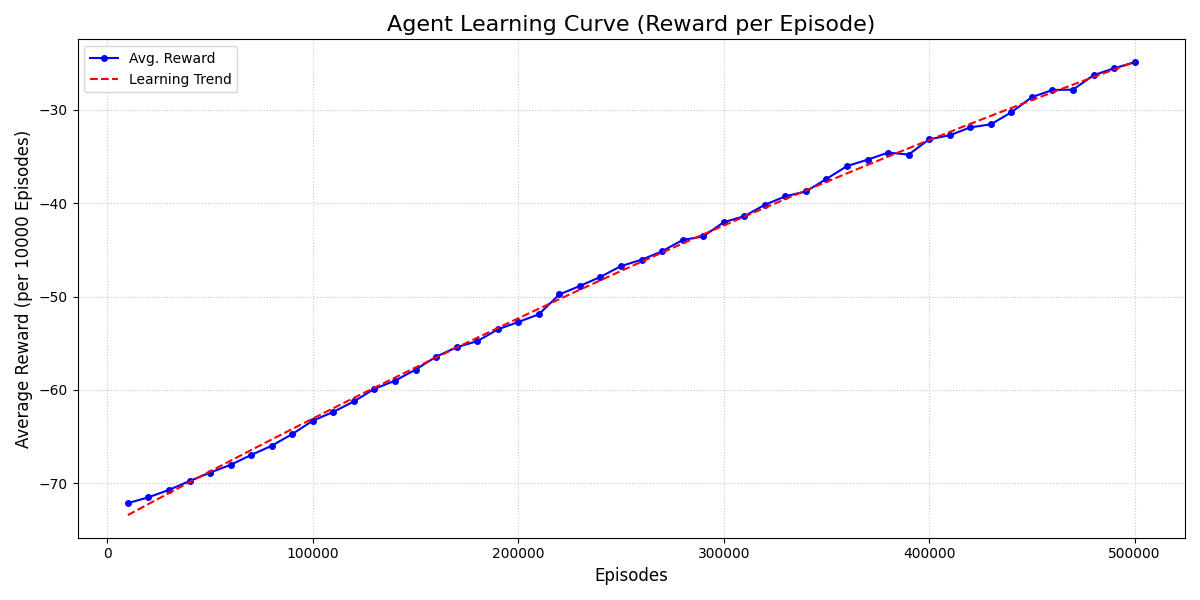

╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│                                       Starting Final 2000-Game Evaluation                                       │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

✅ Q-table policy loaded from c:\Users\reddy\Desktop\ML_Hackathon\rl\policy.pkl
✅ Using HMM model from previous cell.
HangmanEnv: Successfully loaded 49979 words from c:\Users\reddy\Desktop\ML_Hackathon\data\corpus.txt


Running Evaluation: 100%|██████████| 2000/2000 [00:02<00:00, 903.52it/s] 


==================================================

HACKATHON EVALUATION RESULTS

==================================================

         Core Scoring Metrics         
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃ Metric                    ┃ Value  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│ Total Games               │ 2000   │
│ Total Wins                │ 829    │
│ Success Rate              │ 41.45% │
│ Total Wrong Guesses       │ 10284  │
│ Total Repeated Guesses    │ 0      │
└───────────────────────────┴────────┘

╭──────────────────────────────────────────────── 🏆 FINAL SCORE ─────────────────────────────────────────────────╮
│                                                                                                                 │
│                                                     -50,591                                                     │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

           Detailed Agent Diagnostics           
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Diagnostic                ┃ Average per Game ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ Avg. Reward / Game        │ -25.38           │
│ Avg. Steps / Game         │ 11.51            │
│ Avg. Steps on Win         │ 12.20            │
│ Avg. Wrong Guesses        │ 5.14             │
│ Avg. Repeated Guesses     │ 0.00             │
└───────────────────────────┴──────────────────┘

==================================================

╭────────────────────────────────────────────────── ✨ Summary ───────────────────────────────────────────────────╮
│                                             Evaluation Complete! 🎉                                             │
│                                                                                                                 │
│                                                 Win Rate: 41.4%                                                 │
│                                              Final Score: -50,591                                               │
│                                           Avg Reward per Game: -25.38                                           │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

In [6]:
# Cell 6: Part 5 - Final Evaluation & Results
from IPython.display import Image, display
from rich.console import Console
from rich.table import Table
from rich.panel import Panel
from rich.text import Text

# --- 1. Display the Learning Curve Plot ---
print(f"Loading plot from: {PLOT_PATH}")
if os.path.exists(PLOT_PATH):
    display(Image(filename=PLOT_PATH))
else:
    print(f"❌ Plot file not found at {PLOT_PATH}.")
    print("Please run rl/train_rl.py to generate the plot.")

# --- 2. Run the Full 2000-Game Evaluation ---
# (This is a copy of the logic from main.py)

console = Console()
console.print(Panel(
    Text("Starting Final 2000-Game Evaluation", style="bold white", justify="center"),
    border_style="blue"
))

# Load agent and HMM
agent = QLearningAgent(epsilon=0.0)
agent.load_policy(POLICY_PATH)

# Use existing HMM model if available
if 'hmm_model' not in locals():
    with open(HMM_MODEL_PATH, 'rb') as f:
        hmm_model = pickle.load(f)
    print("✅ HMM model loaded.")
else:
    print("✅ Using HMM model from previous cell.")

env = HangmanEnvironment(corpus_path=CORPUS_PATH)

# --- Metric Trackers ---
total_wins = 0
total_wrong_guesses = 0
total_repeated_guesses = 0
total_reward_sum = 0.0
total_steps = 0
total_steps_on_win = 0

for _ in tqdm(range(2000), desc="Running Evaluation"):
    state_dict = env.reset()
    done = False
    game_reward, game_steps = 0.0, 0
    
    while not done:
        state = agent.get_simple_state(state_dict)
        # Use original HMM predict_letter_probs function
        hmm_probs = predict_letter_probs(
            state_dict["masked_word"].lower(),
            {l.lower() for l in state_dict["guessed_letters"]},
            hmm_model
        )
        action_letter = agent.choose_action(
            state, hmm_probs, state_dict["guessed_letters"]
        )
        
        if action_letter in state_dict["guessed_letters"]:
            total_repeated_guesses += 1
        elif action_letter not in env.secret_word:
            total_wrong_guesses += 1
        
        state_dict, reward, done = env.step(action_letter)
        game_reward += reward
        game_steps += 1

    total_reward_sum += game_reward
    total_steps += game_steps
    if state_dict["lives_left"] > 0:
        total_wins += 1
        total_steps_on_win += game_steps
        
# --- Calculate & Display Final Metrics ---
success_rate = total_wins / 2000
final_score = (success_rate * 2000) - (total_wrong_guesses * 5) - (total_repeated_guesses * 2)

avg_reward = total_reward_sum / 2000
avg_steps = total_steps / 2000
avg_wrong = total_wrong_guesses / 2000
avg_repeated = total_repeated_guesses / 2000
avg_steps_win = total_steps_on_win / total_wins if total_wins > 0 else 0 

# --- Rich Table Output ---
console.print("\n\n" + "="*50, style="blue")
console.print(Text("HACKATHON EVALUATION RESULTS", style="bold white", justify="center"))
console.print("="*50, style="blue")

score_table = Table(title="Core Scoring Metrics", border_style="green", show_header=True, header_style="bold magenta")
score_table.add_column("Metric", style="dim", width=25)
score_table.add_column("Value", style="bold")
score_table.add_row("Total Games", "2000")
score_table.add_row("Total Wins", f"{total_wins}")
score_table.add_row("Success Rate", f"{success_rate:.2%}")
score_table.add_row("Total Wrong Guesses", f"{total_wrong_guesses}")
score_table.add_row("Total Repeated Guesses", f"{total_repeated_guesses}")
console.print(score_table)

console.print(Panel(
    Text(f"{final_score:,.0f}", style="bold bright_green" if final_score > 0 else "bold bright_red", justify="center"),
    title="🏆 FINAL SCORE",
    border_style="bold green" if final_score > 0 else "bold red",
    padding=(1, 4)
))

diag_table = Table(title="Detailed Agent Diagnostics", border_style="cyan", show_header=True, header_style="bold magenta")
diag_table.add_column("Diagnostic", style="dim", width=25)
diag_table.add_column("Average per Game", style="bold")
diag_table.add_row("Avg. Reward / Game", f"{avg_reward:.2f}")
diag_table.add_row("Avg. Steps / Game", f"{avg_steps:.2f}")
diag_table.add_row("Avg. Steps on Win", f"{avg_steps_win:.2f}")
diag_table.add_row("Avg. Wrong Guesses", f"{avg_wrong:.2f}")
diag_table.add_row("Avg. Repeated Guesses", f"{avg_repeated:.2f}")
console.print(diag_table)
console.print("="*50, style="blue")

# --- Summary Message ---
console.print("\n")
console.print(Panel(
    Text(f"Evaluation Complete! 🎉\n\n"
         f"Win Rate: {success_rate:.1%}\n"
         f"Final Score: {final_score:,.0f}\n"
         f"Avg Reward per Game: {avg_reward:.2f}",
         style="bold cyan", justify="center"),
    title="✨ Summary",
    border_style="bright_blue"
))
